In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# 1. Изучаем данные

## 1.1. Признаки товаров

In [3]:
item_features.head(3)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


In [4]:
item_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   item_id               92353 non-null  int64 
 1   manufacturer          92353 non-null  int64 
 2   department            92353 non-null  object
 3   brand                 92353 non-null  object
 4   commodity_desc        92353 non-null  object
 5   sub_commodity_desc    92353 non-null  object
 6   curr_size_of_product  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


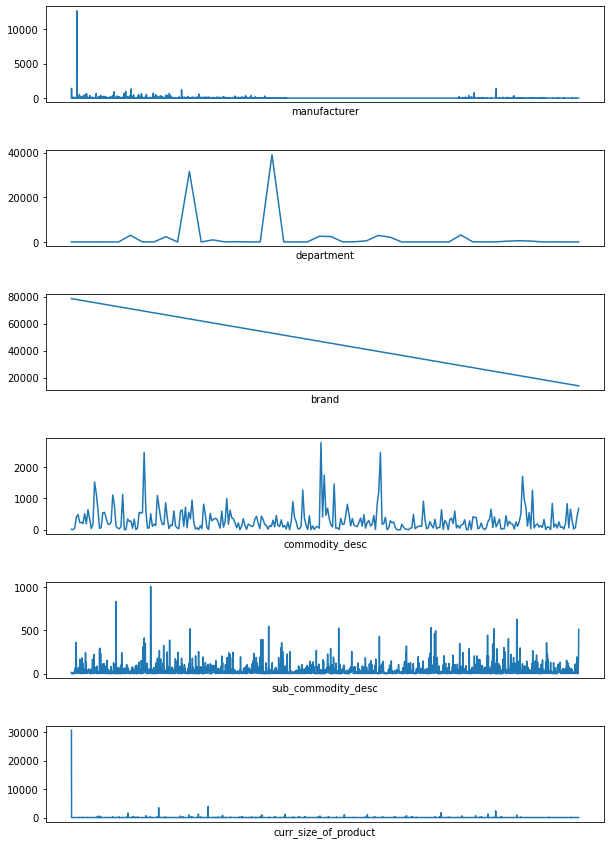

In [5]:
fig, axes = plt.subplots(nrows=6, ncols=1, figsize=(10, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, feature in enumerate(item_features.columns[1:]):
    #axes[i].set_title(feature)
    axes[i].set_xticks([])
    item_features.groupby(feature)['item_id'].count().plot(ax=axes[i])    

По номеру производителя мы врят ли что-то поймем, просто примем тот факт, что производитель 69 производит очень много разных продуктов. К тому же все его товары под брендом Private

In [6]:
item_features.groupby('manufacturer')['item_id'].count().sort_values(ascending=False).head(3)

manufacturer
69      12676
2        1411
5423     1376
Name: item_id, dtype: int64

С отделами всё логично - бакалея и лекарства самые разнообразные

In [7]:
item_features.groupby('department')['item_id'].count().sort_values(ascending=False).head(3)

department
GROCERY    39021
DRUG GM    31529
PRODUCE     3118
Name: item_id, dtype: int64

In [8]:
item_features.groupby('commodity_desc')['item_id'].count().sort_values(ascending=False).head(7)

commodity_desc
GREETING CARDS/WRAP/PARTY SPLY    2785
CANDY - PACKAGED                  2475
MAKEUP AND TREATMENT              2467
HAIR CARE PRODUCTS                1744
SOFT DRINKS                       1704
BAG SNACKS                        1523
HISPANIC                          1460
Name: item_id, dtype: int64

In [9]:
item_features.groupby('sub_commodity_desc')['item_id'].count().sort_values(ascending=False).head(7)

sub_commodity_desc
CARDS EVERYDAY         1005
BEERALEMALT LIQUORS     833
SPICES & SEASONINGS     629
GIFT-WRAP EVERYDAY      547
POTATO CHIPS            531
MAYBELLINE              525
SHAMPOO                 518
Name: item_id, dtype: int64

А вот объемы/размеры товара заполнены не везде. Среди таковых присутствуют как товары, для которых этот параметр не важен (например, книги), так и те, для которых он по идее должен быть.

In [10]:
item_features.groupby('curr_size_of_product')['item_id'].count().sort_values(ascending=False).head(3)

curr_size_of_product
         30607
16 OZ     3924
12 OZ     3473
Name: item_id, dtype: int64

In [11]:
item_features.loc[item_features['curr_size_of_product']==' ', 'commodity_desc'].unique()[20:30]

array(['BOOKSTORE', 'BATH TISSUES', 'SPRING/SUMMER SEASONAL',
       'CHARCOAL AND LIGHTER FLUID', 'SOAP - LIQUID & BAR',
       'SALD DRSNG/SNDWCH SPRD', 'REFRGRATD JUICES/DRNKS',
       'MOLASSES/SYRUP/PANCAKE MIXS', 'GREETING CARDS/WRAP/PARTY SPLY',
       'SOFT DRINKS'], dtype=object)

## 1.2. Признаки пользователя

In [12]:
user_features.head(3)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


Данные имеются всего на 801 пользователя

In [13]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age_desc             801 non-null    object
 1   marital_status_code  801 non-null    object
 2   income_desc          801 non-null    object
 3   homeowner_desc       801 non-null    object
 4   hh_comp_desc         801 non-null    object
 5   household_size_desc  801 non-null    object
 6   kid_category_desc    801 non-null    object
 7   user_id              801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


In [32]:
user_features.columns[:-1]

Index(['age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc',
       'hh_comp_desc', 'household_size_desc', 'kid_category_desc'],
      dtype='object')

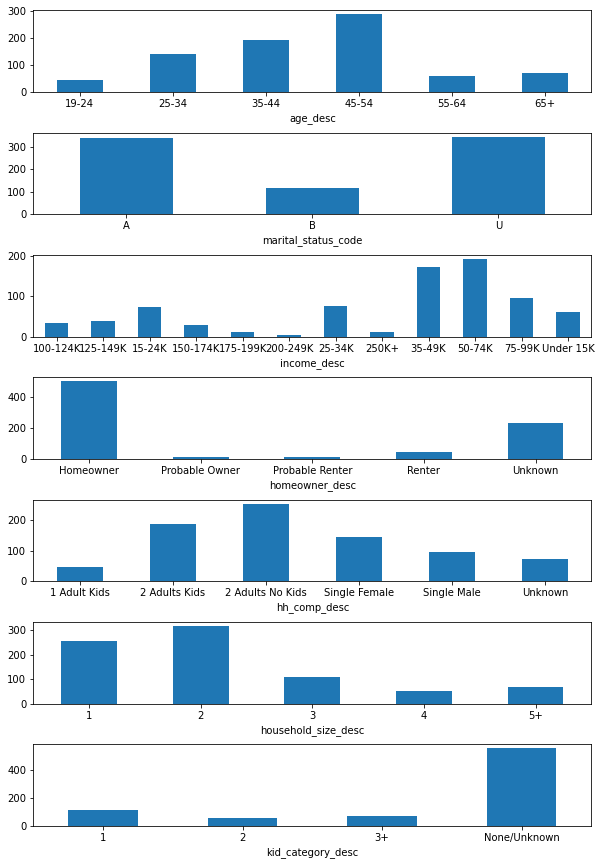

In [16]:
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(10, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

for i, feature in enumerate(user_features.columns[:-1]):
    #axes[i].set_title(feature)
    axes[i].set_xticks([])
    user_features.groupby(feature)['user_id'].count().plot(ax=axes[i], kind='bar')    

## 1.3 Основной дата-сет

В графиках явно есть какая-то цикличность. <br>
Первые 20 недель идет рост всего, как будто сеть магазинов только открылась.

<AxesSubplot:xlabel='week_no'>

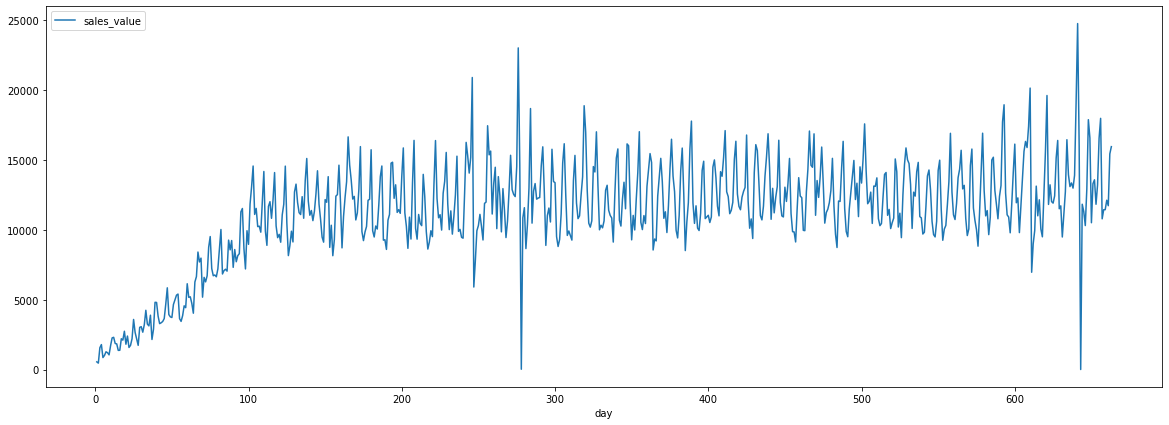

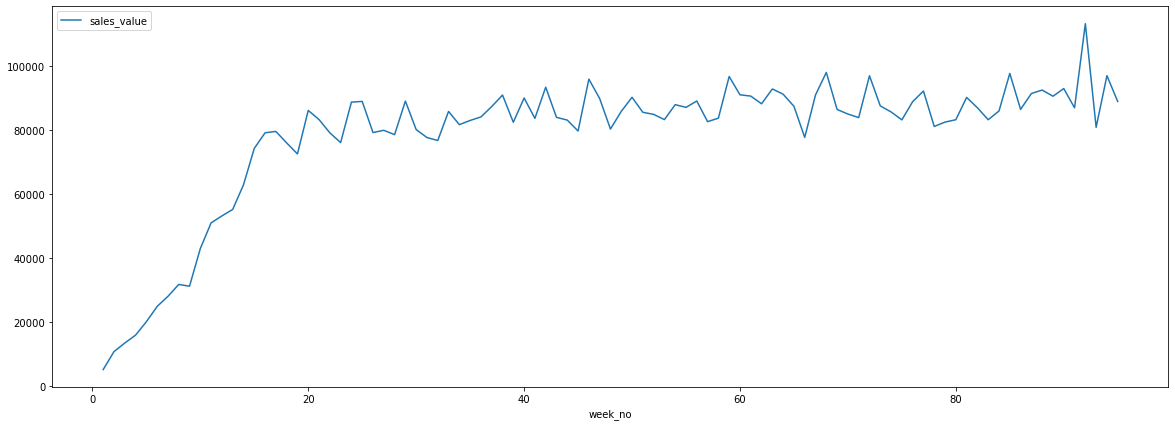

In [17]:
data[['day', 'sales_value']].groupby('day').sum().plot(figsize=(20, 7))
data[['week_no', 'sales_value']].groupby('week_no').sum().plot(figsize=(20, 7))

In [18]:
data = data.merge(item_features, on='item_id', how='left')

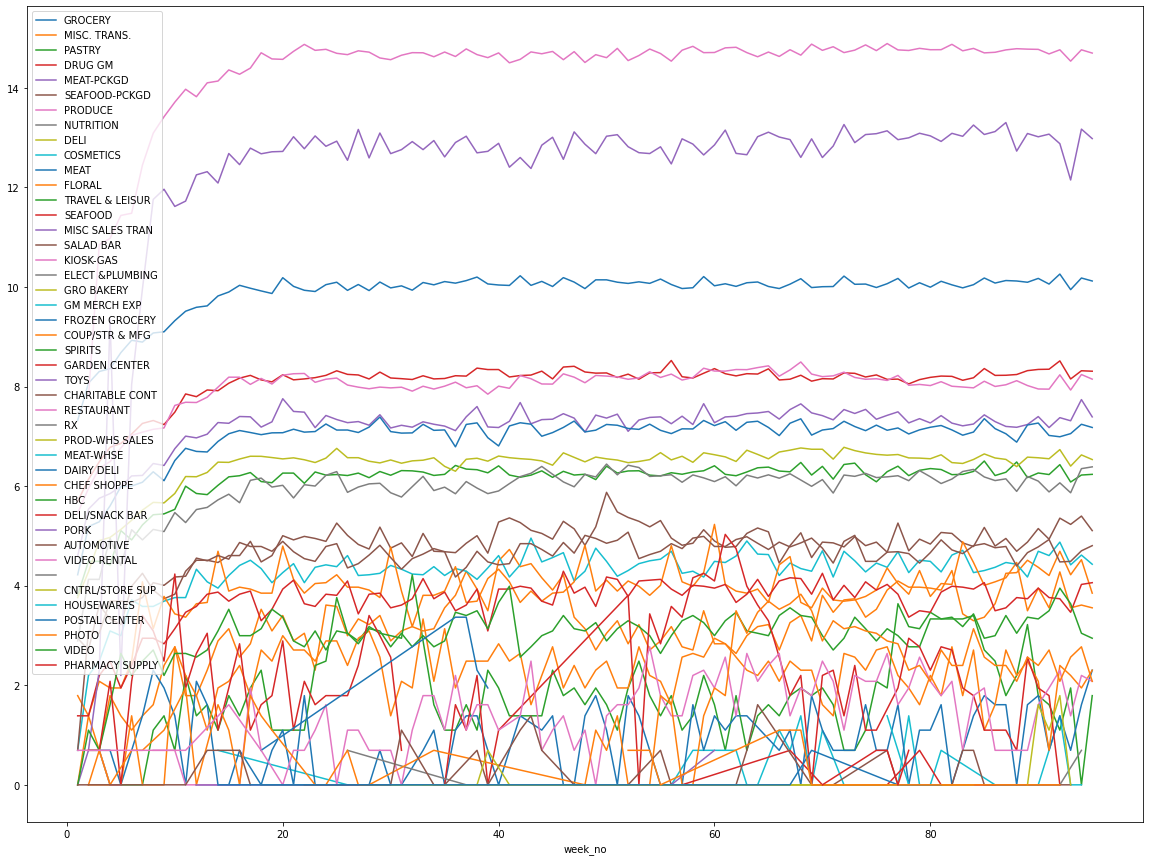

In [19]:
for dep in item_features['department'].unique():
    data.loc[data.department==dep].groupby('week_no')['quantity'].sum().apply(lambda x: np.log(x)).plot(figsize=(20,15), legend=True, label=dep)